In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import missingno as msno

In [84]:
# Step 1: Load datasets
lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')

In [85]:
# Step 2: Select relevant columns (Expanded)
lassa_fever_data_relevant = lassa_fever_data[[
    'Stateofresidence_updated', 'date_symptom_onset2', 'case_classification_recode',
    'age_recode', 'sex_new2', 'pregnancy_new', 'contact_with_source_case_new', 
    'direct_contact_probable_case', 'rodents_excreta', 'fever_new', 'outcome_case',
    'acute_hearing_loss', 'bleeding_gums', 'chest_pain', 'diarrhea_new', 'difficulty_breathing'
]].copy()

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation']].copy()

mobility_data_relevant = mobility_data[['sub_region_1', 'date', 'workplaces_percent_change_from_baseline',
                                        'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline']].copy()


In [86]:
# Step 3: Rename columns for consistency
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Step 4: Convert the date columns to datetime format
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Step 5: Add 'month' and 'year' to each dataset
lassa_fever_data_relevant['month'] = lassa_fever_data_relevant['date'].dt.month
lassa_fever_data_relevant['year'] = lassa_fever_data_relevant['date'].dt.year

climatic_data_relevant['month'] = climatic_data_relevant['date'].dt.month
climatic_data_relevant['year'] = climatic_data_relevant['date'].dt.year

mobility_data_relevant['month'] = mobility_data_relevant['date'].dt.month
mobility_data_relevant['year'] = mobility_data_relevant['date'].dt.year

In [87]:
lassa_fever_data.isnull().sum()

DID                                    0
Disease                                0
Pregnancy                              0
DateofdischargeortransferMdyyyy    19043
DateofdeathMdyyyy                  19425
                                   ...  
age_group3                             0
length_stay_hospital               19414
DateofreportMdyyyy                     0
date_report_months                     0
date_onset_months                   3427
Length: 99, dtype: int64

In [88]:
# Step 6: Handle missing or invalid values
lassa_fever_data_relevant = lassa_fever_data_relevant.dropna(subset=['state'])
lassa_fever_data_relevant.fillna(method='ffill', inplace=True)

# Merging datasets based on 'state' and 'date'
merged_data = lassa_fever_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = merged_data.merge(mobility_data_relevant, on=['state', 'date'], how='left')


In [89]:
lassa_fever_data

,DID,Disease,Pregnancy,DateofdischargeortransferMdyyyy,DateofdeathMdyyyy,Symptomatic,InitialSampleFinalLaboratoryResultPathogentest,LatestSampleDate,LatestSampleFinalLaboratoryResultPathogentest,date_of_outcome,...,area_type_new,educ_updatedcat,Stateofresidence_updated,occupation_updated_new,Stateofresidence_updated_new,age_group3,length_stay_hospital,DateofreportMdyyyy,date_report_months,date_onset_months
0,0001,Lassa,,2021-12-31,NaN,Yes,,NaN,,,...,NaN,No formal education,Bauchi,Student,Bauchi,60+,2.0,2021-12-31,12.0,12.0
1,0002,Lassa,No,NaN,NaN,Yes,POSITIVE,2018-03-16,PENDING,,...,NaN,No formal education,Ondo,Student,Ondo,60+,NaN,2021-12-31,12.0,12.0
2,0003,Lassa,No,NaN,NaN,Yes,POSITIVE,NaN,,,...,NaN,No formal education,Ondo,Housewife,Ondo,20-29,NaN,2021-12-31,12.0,12.0
3,0004,Lassa,No,NaN,NaN,Yes,POSITIVE,NaN,,,...,NaN,Secondary,Ondo,Student,Ondo,10-19,NaN,2021-12-31,12.0,1.0
4,0005,Lassa,,NaN,NaN,Yes,POSITIVE,NaN,,,...,NaN,Secondary,Ondo,farming/livestock,Ondo,30-39,NaN,2021-12-30,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,20058,Lassa,,NaN,NaN,Yes,NEGATIVE,NaN,,26/10/2018,...,Urban,Tertiary,Ondo,Unemployed,Ondo,40-49,NaN,2018-09-26,9.0,12.0
20058,20059,Lassa,,NaN,NaN,Yes,PENDING,NaN,,26/10/2018,...,NaN,Tertiary,Ondo,NaN,Ondo,30-39,NaN,2018-09-07,9.0,12.0
20059,20060,Lassa,,NaN,2018-10-26,Yes,,NaN,,26/10/2018,...,Rural,Tertiary,Taraba,NaN,Taraba,10-19,NaN,2018-04-06,4.0,12.0
20060,20061,Lassa,,NaN,NaN,Yes,,NaN,,,...,Rural,Secondary,Taraba,Trader,Taraba,10-19,NaN,2018-02-01,2.0,12.0


In [90]:
lassa_fever_data_relevant

,state,date,case_classification_recode,age_recode,sex_new2,pregnancy_new,contact_with_source_case_new,direct_contact_probable_case,rodents_excreta,fever_new,outcome_case,acute_hearing_loss,bleeding_gums,chest_pain,diarrhea_new,difficulty_breathing,month,year
0,Bauchi,2021-12-27,negative,9,2.0,NaN,No,NaN,NaN,Yes,No Outcome Yet,No,No,Yes,No,No,12.0,2021.0
1,Ondo,2021-12-27,negative,6,1.0,No,No,NaN,NaN,Yes,No Outcome Yet,No,No,No,No,No,12.0,2021.0
2,Ondo,2021-12-26,negative,29,1.0,No,No,NaN,NaN,Yes,No Outcome Yet,No,No,Yes,No,No,12.0,2021.0
3,Ondo,2022-01-29,negative,12,1.0,No,Unknown,NaN,NaN,Yes,No Outcome Yet,No,No,No,No,No,1.0,2022.0
4,Ondo,2021-12-24,positive,35,2.0,No,No,NaN,NaN,Yes,Recovered,No,No,No,No,No,12.0,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,Ondo,2017-12-29,positive,39,2.0,No,No,UNKNOWN,YES,Yes,Recovered,No,No,No,No,No,12.0,2017.0
20058,Ondo,2017-12-28,positive,32,2.0,No,No,UNKNOWN,YES,Yes,Recovered,No,No,No,Yes,No,12.0,2017.0
20059,Taraba,2017-12-30,positive,18,1.0,No,No,UNKNOWN,YES,Yes,Deceased,No,No,No,Yes,No,12.0,2017.0
20060,Taraba,2017-12-28,positive,16,2.0,No,No,UNKNOWN,YES,Yes,Recovered,No,No,No,Yes,No,12.0,2017.0


In [91]:
merged_data

,state,date,case_classification_recode,age_recode,sex_new2,pregnancy_new,contact_with_source_case_new,direct_contact_probable_case,rodents_excreta,fever_new,...,temperature,humidity,precipitation,month_y,year_y,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transit_stations_percent_change_from_baseline,month,year
0,Bauchi,2021-12-27,negative,9,2.0,NaN,No,NaN,NaN,Yes,...,18.82,55.88,0.00,12.0,2021.0,-25.0,3.0,NaN,12.0,2021.0
1,Bauchi,2021-12-27,negative,9,2.0,NaN,No,NaN,NaN,Yes,...,18.82,55.88,0.00,12.0,2021.0,-29.0,8.0,NaN,12.0,2021.0
2,Bauchi,2021-12-27,negative,9,2.0,NaN,No,NaN,NaN,Yes,...,18.82,55.88,0.00,12.0,2021.0,NaN,NaN,NaN,12.0,2021.0
3,Ondo,2021-12-27,negative,6,1.0,No,No,NaN,NaN,Yes,...,25.37,81.31,1.98,12.0,2021.0,-39.0,10.0,27.0,12.0,2021.0
4,Ondo,2021-12-27,negative,6,1.0,No,No,NaN,NaN,Yes,...,25.37,81.31,1.98,12.0,2021.0,-46.0,NaN,NaN,12.0,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62903,Ondo,2017-12-28,positive,32,2.0,No,No,UNKNOWN,YES,Yes,...,22.62,67.19,0.00,12.0,2017.0,NaN,NaN,NaN,NaN,NaN
62904,Taraba,2017-12-30,positive,18,1.0,No,No,UNKNOWN,YES,Yes,...,26.07,30.94,0.00,12.0,2017.0,NaN,NaN,NaN,NaN,NaN
62905,Taraba,2017-12-28,positive,16,2.0,No,No,UNKNOWN,YES,Yes,...,25.26,34.06,0.00,12.0,2017.0,NaN,NaN,NaN,NaN,NaN
62906,Taraba,2020-03-27,negative,45,2.0,No,No,UNKNOWN,YES,Yes,...,31.94,49.75,0.03,3.0,2020.0,-10.0,NaN,NaN,3.0,2020.0


In [92]:
merged_data.isnull().sum()

state                                                0
date                                                 0
case_classification_recode                           0
age_recode                                           0
sex_new2                                             0
pregnancy_new                                        3
contact_with_source_case_new                         0
direct_contact_probable_case                     14908
rodents_excreta                                  14908
fever_new                                            0
outcome_case                                         0
acute_hearing_loss                                   0
bleeding_gums                                        0
chest_pain                                           0
diarrhea_new                                         0
difficulty_breathing                                 0
month_x                                              0
year_x                                               0
temperatur

In [93]:
# Impute missing values in 'pregnancy_new' with the mode
merged_data['pregnancy_new'].fillna(merged_data['pregnancy_new'].mode()[0], inplace=True)

# Impute missing values in 'direct_contact_probable_case' with "NO"
merged_data['direct_contact_probable_case'].fillna('UNKNOWN', inplace=True)

# Impute missing values in 'rodents_excreta' with "NO"
merged_data['rodents_excreta'].fillna('UNKNOWN', inplace=True)

# Impute missing values in 'workplaces_percent_change_from_baseline' with the mean
merged_data['workplaces_percent_change_from_baseline'].fillna(merged_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'residential_percent_change_from_baseline' with the mean
merged_data['residential_percent_change_from_baseline'].fillna(merged_data['residential_percent_change_from_baseline'].mean(), inplace=True)

# Impute missing values in 'transit_stations_percent_change_from_baseline' with the mean
merged_data['transit_stations_percent_change_from_baseline'].fillna(merged_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)

# Verify that there are no missing values left
print(merged_data.isnull().sum())

state                                                0
date                                                 0
case_classification_recode                           0
age_recode                                           0
sex_new2                                             0
pregnancy_new                                        0
contact_with_source_case_new                         0
direct_contact_probable_case                         0
rodents_excreta                                      0
fever_new                                            0
outcome_case                                         0
acute_hearing_loss                                   0
bleeding_gums                                        0
chest_pain                                           0
diarrhea_new                                         0
difficulty_breathing                                 0
month_x                                              0
year_x                                               0
temperatur

In [94]:
merged_data = merged_data.dropna(subset=['month', 'year'])

In [95]:
merged_data

,state,date,case_classification_recode,age_recode,sex_new2,pregnancy_new,contact_with_source_case_new,direct_contact_probable_case,rodents_excreta,fever_new,...,temperature,humidity,precipitation,month_y,year_y,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transit_stations_percent_change_from_baseline,month,year
0,Bauchi,2021-12-27,negative,9,2.0,No,No,UNKNOWN,UNKNOWN,Yes,...,18.82,55.88,0.00,12.0,2021.0,-25.000000,3.000000,22.958762,12.0,2021.0
1,Bauchi,2021-12-27,negative,9,2.0,No,No,UNKNOWN,UNKNOWN,Yes,...,18.82,55.88,0.00,12.0,2021.0,-29.000000,8.000000,22.958762,12.0,2021.0
2,Bauchi,2021-12-27,negative,9,2.0,No,No,UNKNOWN,UNKNOWN,Yes,...,18.82,55.88,0.00,12.0,2021.0,-10.525009,7.148551,22.958762,12.0,2021.0
3,Ondo,2021-12-27,negative,6,1.0,No,No,UNKNOWN,UNKNOWN,Yes,...,25.37,81.31,1.98,12.0,2021.0,-39.000000,10.000000,27.000000,12.0,2021.0
4,Ondo,2021-12-27,negative,6,1.0,No,No,UNKNOWN,UNKNOWN,Yes,...,25.37,81.31,1.98,12.0,2021.0,-46.000000,7.148551,22.958762,12.0,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55142,Plateau,2020-12-20,negative,58,1.0,No,No,NO,NO,Yes,...,26.37,26.94,0.00,12.0,2020.0,-23.000000,3.000000,8.000000,12.0,2020.0
55143,Plateau,2020-12-20,negative,58,1.0,No,No,NO,NO,Yes,...,26.37,26.94,0.00,12.0,2020.0,-27.000000,7.000000,1.000000,12.0,2020.0
55144,Plateau,2020-12-20,negative,58,1.0,No,No,NO,NO,Yes,...,26.37,26.94,0.00,12.0,2020.0,-4.000000,7.148551,22.958762,12.0,2020.0
62906,Taraba,2020-03-27,negative,45,2.0,No,No,UNKNOWN,YES,Yes,...,31.94,49.75,0.03,3.0,2020.0,-10.000000,7.148551,22.958762,3.0,2020.0


In [96]:
# Verify that there are no missing values left
print(merged_data.isnull().sum())

state                                            0
date                                             0
case_classification_recode                       0
age_recode                                       0
sex_new2                                         0
pregnancy_new                                    0
contact_with_source_case_new                     0
direct_contact_probable_case                     0
rodents_excreta                                  0
fever_new                                        0
outcome_case                                     0
acute_hearing_loss                               0
bleeding_gums                                    0
chest_pain                                       0
diarrhea_new                                     0
difficulty_breathing                             0
month_x                                          0
year_x                                           0
temperature                                      0
humidity                       

In [97]:
# Step 8: Aggregating merged data by state, year, and month
# Ensure merged_data is a complete copy
merged_data = merged_data.copy()  # Ensure merged_data is not a slice

# Convert categorical columns to numeric (if appropriate)
categorical_columns_to_convert = [
    'fever_new', 
    'acute_hearing_loss', 
    'diarrhea_new', 
    'pregnancy_new', 
    'direct_contact_probable_case', 
    'rodents_excreta'
]

for col in categorical_columns_to_convert:
    if col in merged_data.columns:
        # Convert to numeric, treating NaN as 0 and ensuring errors are coerced to NaN
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce').fillna(0).astype(int)

# Mark hotspots based on case classification
merged_data.loc[:, 'hotspot'] = (merged_data['case_classification_recode'].notna()).astype(int)

agg_funcs = {
    'temperature': 'mean',
    'humidity': 'mean',
    'precipitation': 'mean',
    'workplaces_percent_change_from_baseline': 'mean',
    'residential_percent_change_from_baseline': 'mean',
    'transit_stations_percent_change_from_baseline': 'mean',
    'hotspot': 'sum',  # Count of hotspots (cases)
    'case_classification_recode': 'count',  # Count of total cases
    'fever_new': 'sum',  # Total cases with fever
    'acute_hearing_loss': 'sum',  # Total cases with acute hearing loss
    'diarrhea_new': 'sum',  # Total cases with diarrhea
    'pregnancy_new': 'sum',  # Total cases that are pregnant
    'direct_contact_probable_case': 'sum',  # Total cases with direct contact
    'rodents_excreta': 'sum',  # Total cases with rodents excreta
    'age_recode': 'nunique',  # Count of unique age groups
    'sex_new2': 'nunique'  # Count of unique sex categories
}

# Grouping and aggregating the data
combined_data = merged_data.groupby(['state', 'year', 'month']).agg(agg_funcs).reset_index()

# Make sure to copy combined_data to avoid SettingWithCopyWarning
combined_data = combined_data.copy()

# Rename the count of case_classification_recode to total_cases for clarity
combined_data.rename(columns={'case_classification_recode': 'total_cases'}, inplace=True)

# Define a threshold for hotspots and use .loc to avoid warning
threshold = 5
combined_data.loc[:, 'hotspot'] = (combined_data['total_cases'] > threshold).astype(int)  # Define hotspots based on case count


In [98]:
# Step 9: Fill missing values
combined_data.fillna(method='ffill', inplace=True)

combined_data

,state,year,month,temperature,humidity,precipitation,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transit_stations_percent_change_from_baseline,hotspot,total_cases,fever_new,acute_hearing_loss,diarrhea_new,pregnancy_new,direct_contact_probable_case,rodents_excreta,age_recode,sex_new2
0,Abia,2020.0,2.0,25.730000,75.500000,0.000000,3.579165,5.957125,17.639175,1,6,0,0,0,0,0,0,1,1
1,Abia,2020.0,3.0,27.216667,87.476667,6.983333,5.451190,5.841615,13.970544,1,21,0,0,0,0,0,0,3,1
2,Abia,2020.0,4.0,27.411000,86.031000,3.985000,-40.605002,8.833696,-12.024743,1,10,0,0,0,0,0,0,2,2
3,Abia,2020.0,6.0,26.630000,85.940000,2.170000,-2.142857,7.413043,7.827687,1,7,0,0,0,0,0,0,1,1
4,Abia,2020.0,7.0,24.616154,91.621538,11.684615,3.384615,7.125697,11.432989,1,13,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,Yobe,2020.0,12.0,23.640000,30.000000,0.000000,5.618748,7.148551,22.958762,0,4,0,0,0,0,0,0,1,1
444,Zamfara,2020.0,2.0,23.420000,19.085385,0.000000,-0.513467,7.148551,22.958762,1,13,0,0,0,0,0,0,5,1
445,Zamfara,2020.0,3.0,27.907500,13.262500,0.000000,1.031246,7.148551,22.958762,1,12,0,0,0,0,0,0,4,2
446,Zamfara,2020.0,6.0,26.300000,76.940000,1.780000,14.824997,7.148551,22.958762,0,3,0,0,0,0,0,0,1,1


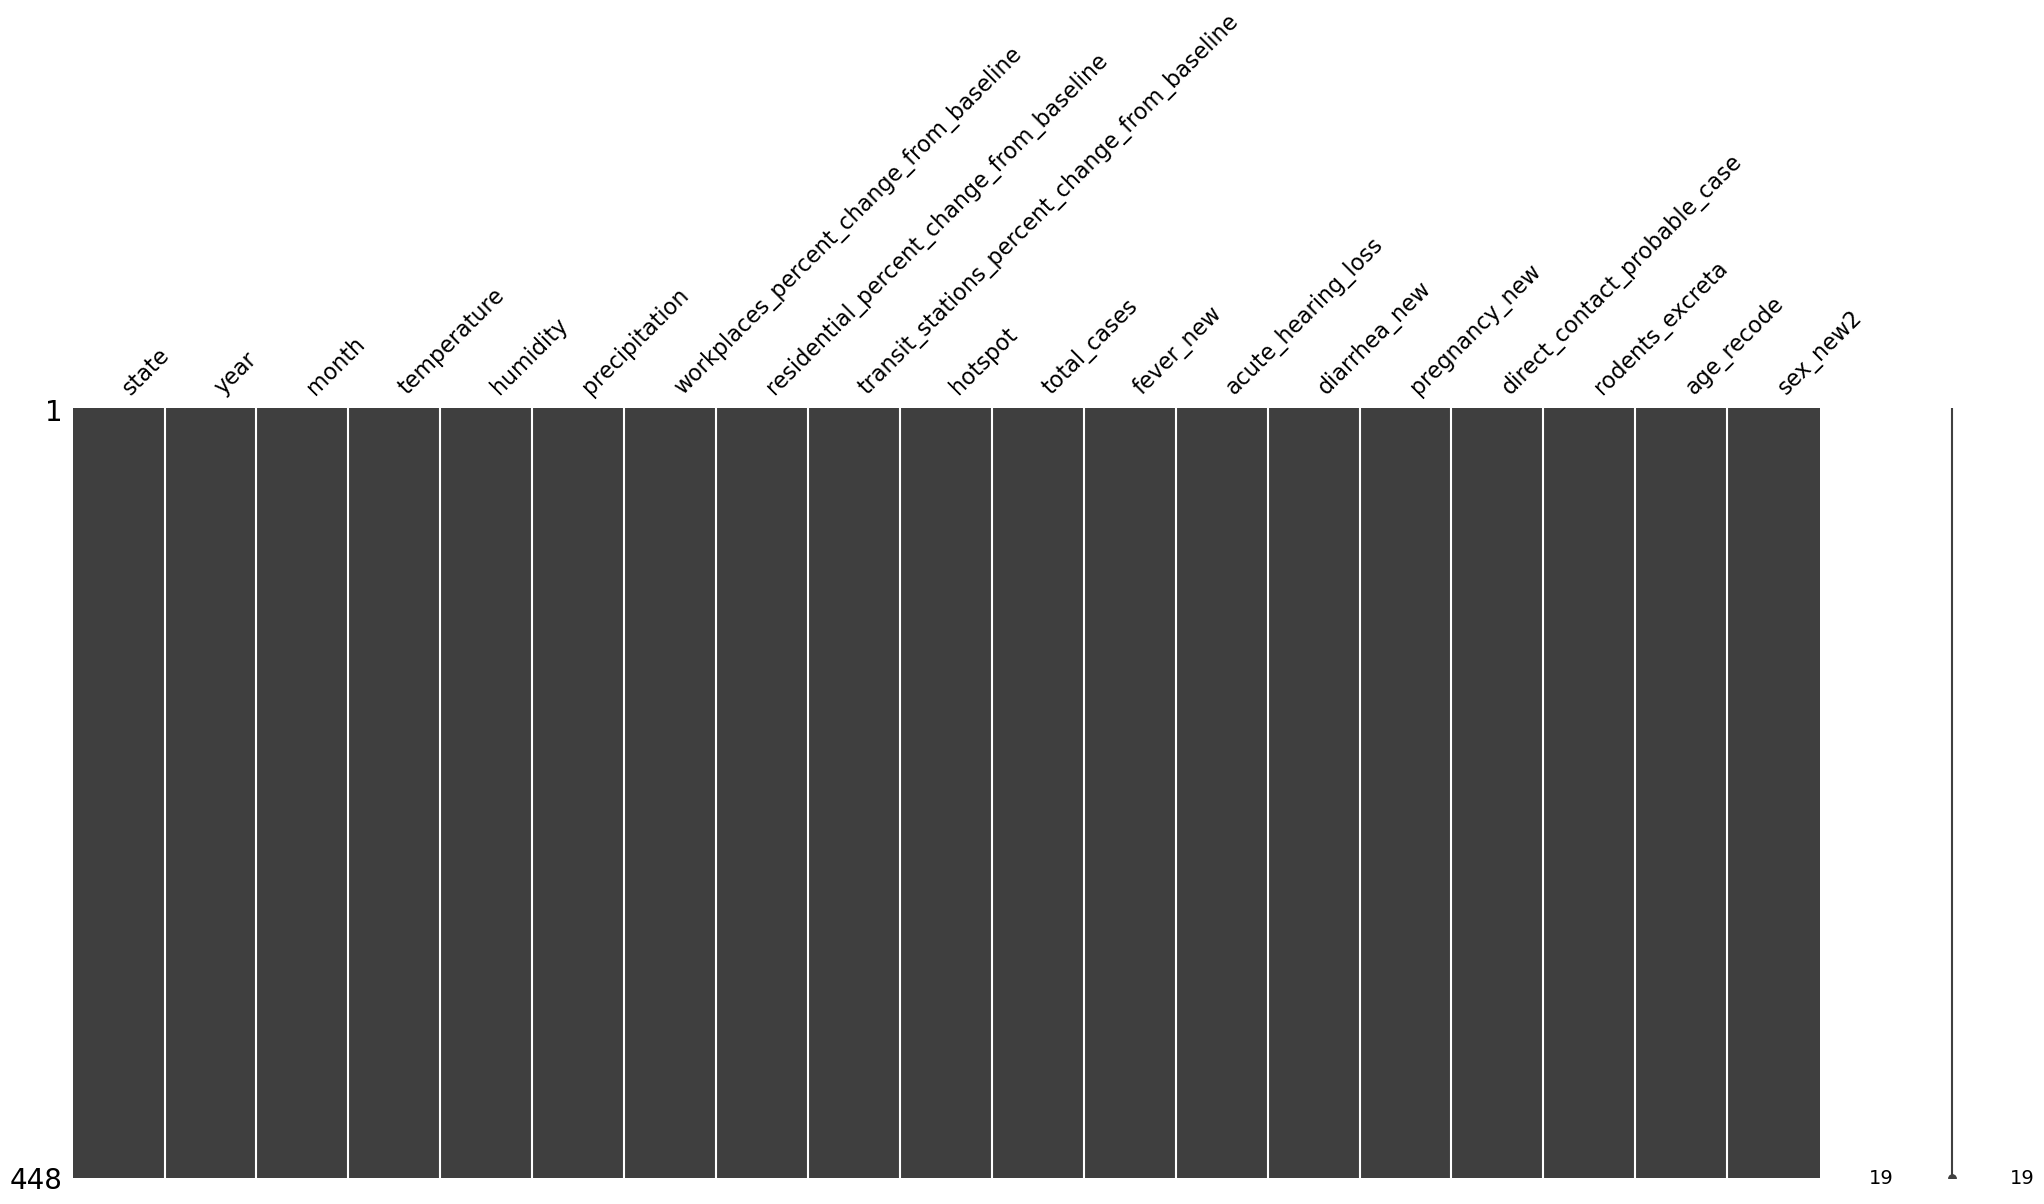

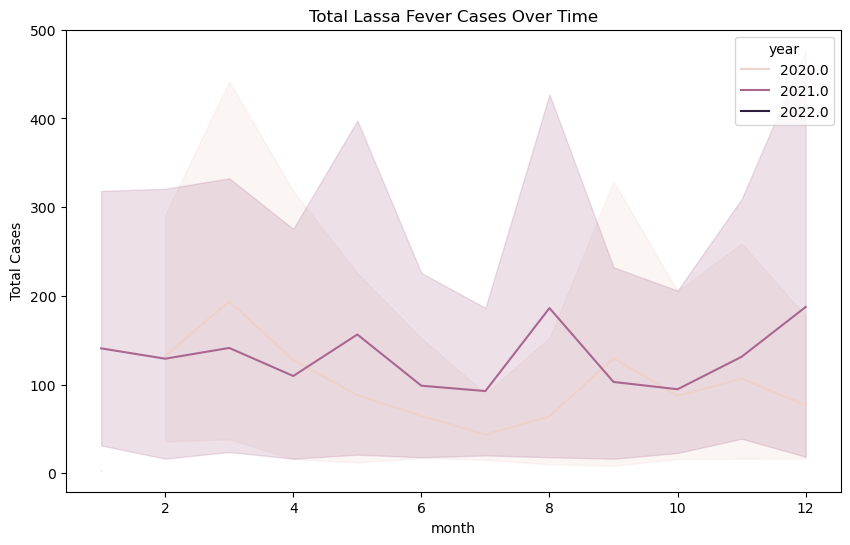

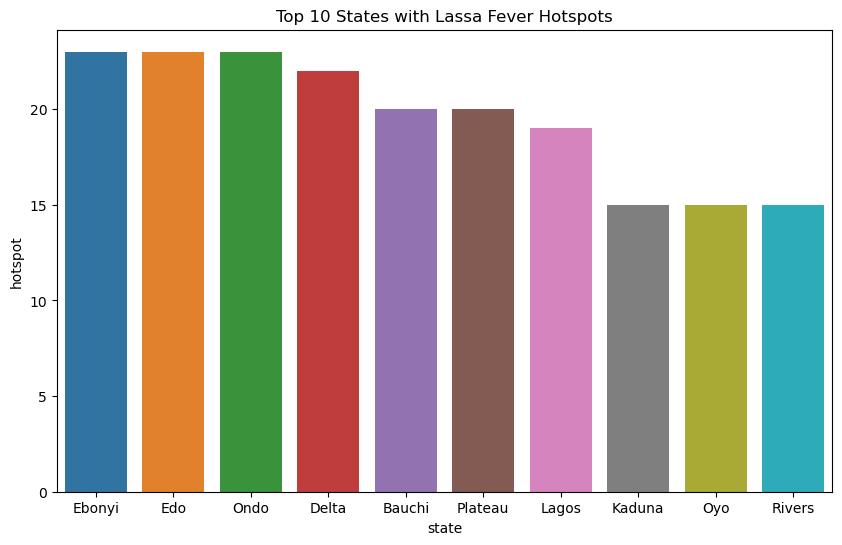

In [99]:
# Step 10: Exploratory Data Analysis (EDA)
# 10.1 Visualize missing data using missingno
msno.matrix(combined_data)
plt.show()

# 10.2 Distribution of Lassa Fever cases over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_data, x='month', y='total_cases', hue='year')
plt.title('Total Lassa Fever Cases Over Time')
plt.ylabel('Total Cases')
plt.show()

# 10.3 Hotspot count by state (Top 10 states)
plt.figure(figsize=(10, 6))
top_states = combined_data.groupby('state')['hotspot'].sum().nlargest(10).reset_index()
sns.barplot(x='state', y='hotspot', data=top_states)
plt.title('Top 10 States with Lassa Fever Hotspots')
plt.show()

# 10.4 Visualize hotspots using a map (with plotly express)
fig = px.choropleth(combined_data, geojson="/Users/m1/Downloads/data/VHF/gadm41_NGA_shp/gadm41_NGA_1.shp",
                     locations='state', featureidkey="properties.NAME_1", color='hotspot',
                     hover_name='state', title='Lassa Fever Hotspots')
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


In [79]:
# Step 11: Define features and target variable
numerical_features = ['temperature', 'humidity', 'precipitation',
                      'workplaces_percent_change_from_baseline',
                      'residential_percent_change_from_baseline',
                      'transit_stations_percent_change_from_baseline', 'month']

categorical_features = ['age_recode', 'sex_new2', 'pregnancy_new', 'rodents_excreta', 'fever_new']

# Define the target variable
y = combined_data['hotspot']

# Define the feature matrix (X) - independent variables
X = combined_data[numerical_features + categorical_features]

# Use ColumnTransformer to apply transformations: scale numeric and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Apply the preprocessing pipeline
X_transformed = preprocessor.fit_transform(X)

# Now proceed with train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [80]:
# Step 12: Train the XGBoost model with Cross-Validation
# Define the model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Accuracy: 0.8814814814814815
ROC AUC Score: 0.939691027926322
Average Precision Score: 0.9798856008016323
Confusion Matrix:
 [[25  8]
 [ 8 94]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76        33
           1       0.92      0.92      0.92       102

    accuracy                           0.88       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.88      0.88      0.88       135



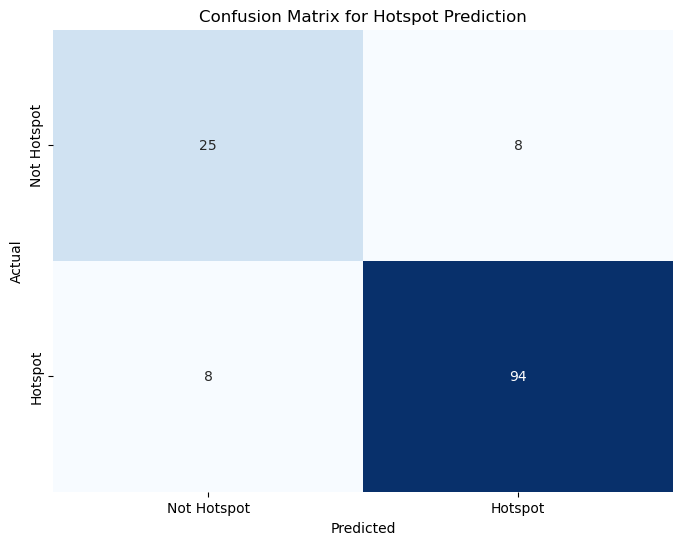

In [81]:
# Step 13: Model Evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display results
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Average Precision Score:", average_precision)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Hotspot', 'Hotspot'], yticklabels=['Not Hotspot', 'Hotspot'])
plt.title('Confusion Matrix for Hotspot Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

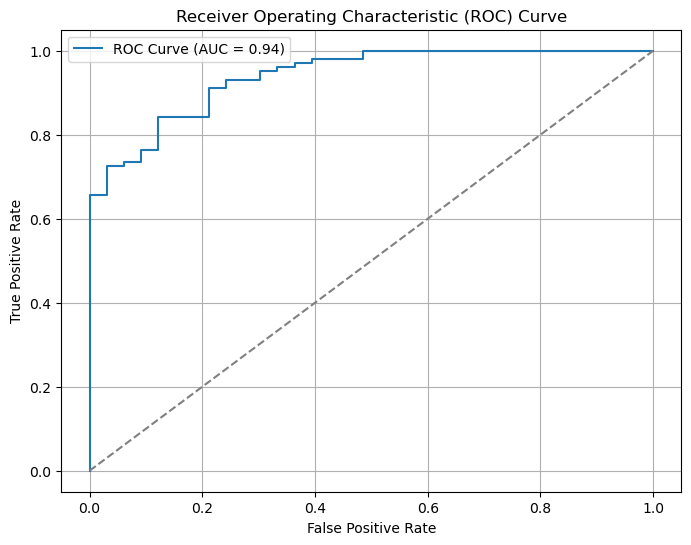

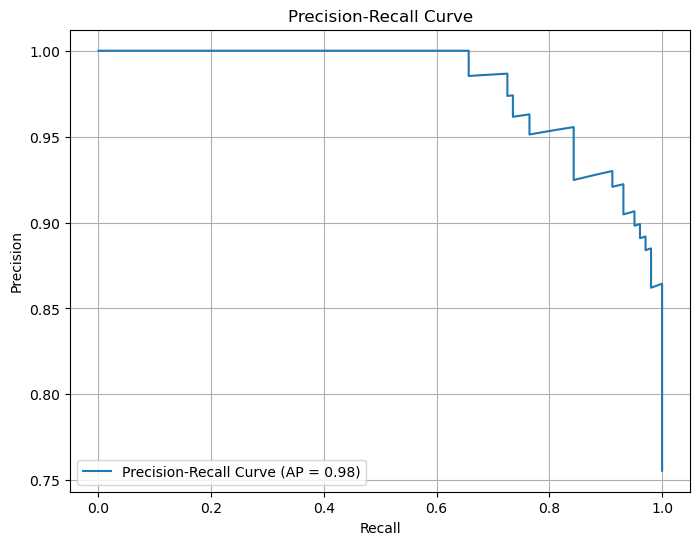

In [82]:
# Step 14: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Step 15: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve (AP = {:.2f})'.format(average_precision))
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()